In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt 
import seaborn as sns
from joblib import dump, load
pd.options.display.max_rows =None

In [2]:
data_path = f"./data/"
model_path = f"./models/"

In [3]:
train_data = pd.read_csv(f"{data_path}processed_train.csv")
test_data = pd.read_csv(f"{data_path}processed_test.csv")

In [4]:
woe_vars = pd.read_csv(f"{data_path}/woe_cat_vars.csv").squeeze()
ref_vars = pd.read_csv(f"{data_path}/woe_ref_vars.csv").squeeze()

print(f"# of woe cat vars: {len(woe_vars)}, # of woe ref vars: {len(ref_vars)}")
print(f"train data shape: {train_data.shape}, test data shape: {test_data.shape}")

# of woe cat vars: 118, # of woe ref vars: 22
train data shape: (373028, 299), test data shape: (93257, 299)


In [5]:
x_train, y_train = train_data.loc[:, woe_vars.to_list()], train_data["good_bad"]
x_test, y_test = test_data.loc[:, woe_vars.to_list()], test_data["good_bad"]

print(f"[xtrain: {x_train.shape}, ytrain: {y_train.shape}], [xtest: {x_test.shape}, y_test: {y_test.shape}")

[xtrain: (373028, 118), ytrain: (373028,)], [xtest: (93257, 118), y_test: (93257,)


In [6]:
# remove one category from each variable to avoid varible dummy trap
x_train = x_train.drop(ref_vars.to_list(), axis=1)
x_test = x_test.drop(ref_vars.to_list(),axis=1)
print(f"[xtrain: {x_train.shape}, ytrain: {y_train.shape}], [xtest: {x_test.shape}, y_test: {y_test.shape}")

[xtrain: (373028, 96), ytrain: (373028,)], [xtest: (93257, 96), y_test: (93257,)


#### PD model development

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [8]:
log_regression = LogisticRegression(solver="liblinear")
log_regression.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

In [9]:
log_regression.intercept_

array([-0.78734368])

In [10]:
log_regression.coef_

array([[ 1.00143087e+00,  8.47198014e-01,  6.70426186e-01,
         5.15955154e-01,  3.42883110e-01,  1.86264724e-01,
         8.95934492e-02,  1.14789389e-01,  9.23197592e-02,
         8.68321059e-02,  2.32103055e-01,  4.96098207e-02,
         9.07832683e-02,  8.37331784e-02,  1.45414359e-01,
         1.54033493e-01,  1.61143979e-01,  2.22112273e-01,
         3.11289753e-01,  3.85409045e-01,  5.35249281e-01,
         1.00662851e-01, -8.36346977e-04,  1.77557558e-01,
         1.94090784e-01,  2.25594757e-01,  1.01209845e-01,
         6.91876317e-02,  6.49721537e-02,  1.56973612e-01,
         2.06065494e-01,  1.46188481e-01,  1.41675694e-01,
         2.05662969e-01,  1.13343892e+00,  9.19644680e-01,
         7.61237038e-01,  5.34441379e-01,  2.23180826e-01,
        -9.69024524e-02,  1.03596317e+00,  6.39376490e-01,
         3.63079189e-01,  1.33150355e-01,  3.19031548e-02,
         6.08640950e-03,  1.29913893e-01,  1.82011384e-01,
         3.02020270e-01,  3.60932633e-01,  4.52705948e-0

In [11]:
from logistic_regression_wrapper import LogisticRegressionWrapper

In [12]:
log_regression_wrapper = LogisticRegressionWrapper(solver="liblinear")

In [13]:
log_regression_wrapper.fit(x_train, y_train)

In [14]:
summary = pd.DataFrame(columns=["feature"], data=x_train.columns.to_list())
summary["coefficients"] = np.transpose(log_regression_wrapper.coef_)
summary["z_score"] = log_regression_wrapper.z_scores
summary['p_value'] = log_regression_wrapper.p_values
summary.index = summary.index + 1
summary.loc[0] = ["intercept", log_regression_wrapper.intercept_[0], np.nan, np.nan]
summary = summary.sort_index()
summary

,feature,coefficients,z_score,p_value
0,intercept,-0.787344,NaN,NaN
1,grade_A,1.001431,10.958730,6.034038e-28
2,grade_B,0.847198,13.932783,4.004452e-44
3,grade_C,0.670426,11.875374,1.589222e-32
4,grade_D,0.515955,9.612760,7.062958e-22
5,grade_E,0.342883,7.134109,9.741612e-13
6,grade_F,0.186265,3.715479,2.028195e-04
7,home_ownership_OWN,0.089593,4.451751,8.517306e-06
8,home_ownership_MORTGAGE,0.114789,9.028209,1.745039e-19
9,addr_state_NY,0.092320,3.810862,1.384833e-04


Each original independent variable is respresented by several dummy variables. If the coefficinets for all those dummy variables are statistically significant, we should retain all of them, and if the coefficients for none of the dummy variables are statistically significant, we shoule remove all of them.

Generally, if a p-value is less than 0.05 (5%), we conclude that the coefficient of a variable is statistically significant.

In [15]:
singinficant_vars = summary.loc[summary["p_value"] < 0.05]
singinficant_vars = singinficant_vars["feature"].values
print(f"{len(singinficant_vars)} vars,\n{singinficant_vars}")

74 vars,
['grade_A' 'grade_B' 'grade_C' 'grade_D' 'grade_E' 'grade_F'
 'home_ownership_OWN' 'home_ownership_MORTGAGE' 'addr_state_NY'
 'addr_state_CA' 'addr_state_TX' 'addr_state_NC_NM'
 'addr_state_NJ_AZ_VA_OK_TN' 'addr_state_AR_PR_MI'
 'addr_state_UT_MA_RI_OH' 'addr_state_KY_MN_GA_SD'
 'addr_state_IN_OR_WA_WI' 'addr_state_IL_SC_CT_KS_CO'
 'addr_state_VT_MS_NH_AK_MT' 'addr_state_WV_WY_DC_ME'
 'verification_status_Not Verified' 'purpose_medical_vacation_wedding'
 'purpose_major_purchase_home_imp_car' 'purpose_credit_card'
 'purpose_debt_consolidation' 'initial_list_status_w' 'term_36'
 'emp_length_1' 'emp_length_2_4' 'emp_length_5_6' 'emp_length_7_9'
 'emp_length_10' 'months_since_issued_date_<117'
 'months_since_issued_date_117_119' 'months_since_issued_date_119_123'
 'months_since_issued_date_123_131' 'months_since_issued_date_131_149'
 'months_since_issued_date_149_172' 'int_rate_<9.54'
 'int_rate_9.54_12.025' 'int_rate_12.025_15.74' 'int_rate_15.74_20.281'
 'annual_inc_<40K_50K' 'a

In [ ]:
df_final_vars = pd.DataFrame(data={"final_features": singinficant_vars})
df_final_vars.to_csv(f"{data_path}model_features.csv")
del df_final_vars

In [16]:
summary.loc[summary["p_value"] >= 0.05]

,feature,coefficients,z_score,p_value
12,addr_state_LA_MO_DE_MD,0.049610,1.794198,0.072782
23,verification_status_Source Verified,-0.000836,-0.061846,0.950686
45,annual_inc_<20K_30K,0.031903,0.745454,0.455997
46,annual_inc_<30K_40K,0.006086,0.149814,0.880912
58,mths_since_last_delinq_>56,-0.012884,-0.589740,0.555365
59,mths_since_last_delinq_missing,-0.172884,-0.930994,0.351856
61,months_since_earliest_cr_line_228_257,-0.053398,-1.261210,0.207233
63,months_since_earliest_cr_line_371_471,-0.007805,-0.194957,0.845426
64,months_since_earliest_cr_line_>486,0.021503,0.494964,0.620626
66,delinq_2yrs_1_3,0.191671,1.570727,0.116246


In [17]:
x_train = x_train.loc[:, singinficant_vars]
x_test = x_test.loc[:, singinficant_vars]

print(f"final train data shape: {x_train.shape}, test shape: {x_test.shape}")

final train data shape: (373028, 74), test shape: (93257, 74)


In [18]:
final_lrw_model = LogisticRegressionWrapper(solver="liblinear")
final_lrw_model.fit(x_train, y_train)

In [19]:
dump(final_lrw_model, f"{model_path}m_zero.joblib")

['./models/m_zero.joblib']

In [20]:
summary = pd.DataFrame(columns=["feature"], data=x_train.columns.to_list())
summary["coefficients"] = np.transpose(final_lrw_model.coef_)
summary["z_score"] = final_lrw_model.z_scores
summary['p_value'] = final_lrw_model.p_values
summary.index = summary.index + 1
summary.loc[0] = ["intercept", final_lrw_model.intercept_[0], np.nan, np.nan]
summary = summary.sort_index()
summary

,feature,coefficients,z_score,p_value
0,intercept,-0.731294,NaN,NaN
1,grade_A,1.016916,11.177022,5.283330e-29
2,grade_B,0.854733,14.177164,1.268703e-45
3,grade_C,0.676734,12.132174,7.133004e-34
4,grade_D,0.521357,9.876736,5.251552e-23
5,grade_E,0.346177,7.431111,1.076890e-13
6,grade_F,0.187647,3.879058,1.048619e-04
7,home_ownership_OWN,0.093031,4.639275,3.496339e-06
8,home_ownership_MORTGAGE,0.118243,9.359285,8.027837e-21
9,addr_state_NY,0.076505,3.425330,6.140520e-04


#### Interpreting model's coefficients 

\begin{equation}
    ln\left ( \frac{odds\left(Y=1 | X_j = 1 \right )}{odds\left( Y=1 | X_j = 0 \right)} \right ) = e^{\beta_j}
\end{equation}


- *Good Borrowers (non-defaulters): 1 i.e Higher coefficient in feature vars*
- *Bad Borrowers (defaulters): 0 i.e. inverse of good one*


Lets take an example, Grade D, which has coefficient of 0.521357. i.e. $e^{\beta_d}$ => $e^{0.521357}$ => 1.65. This means the odds for someone with grade D to be a good borrower is about 1.5X greater than the odds for someone with grade G.

\begin{equation}
    odds\left( Y=1 | Grade = D \right) = 1.65 \times odds\left( Y=1 | Grade = g \right)
\end{equation}

Lets compare grade B with grade D

\begin{equation}
    \frac{odds\left( Y=1 | Grade = B \right) = 2.42 \times odds\left( Y=1 | Grade = g \right)}{odds\left( Y=1 | Grade = D \right) = 1.65 \times odds\left( Y=1 | Grade = g \right)}
\end{equation}

\begin{equation}
\frac{odds\left( Y=1 | Grade = B \right) = 2.42}{odds\left( Y=1 | Grade = D \right) = 1.65} = e^{\beta_b - \beta_d}= 1.467
\end{equation}


Therefore, the odds for someone with grade B to be a good borrower is about 1.4671X greater than the odds for someone with grade D.

In [21]:
np.exp(0.524357)

1.689372232723955

#### Evaluation

In [22]:
x_test.shape

(93257, 74)

In [23]:
test_prediction = final_lrw_model.model.predict(x_test)
test_prediction

array([1, 1, 1, ..., 1, 1, 1])

In [24]:
test_prediction_probability = final_lrw_model.model.predict_proba(x_test)
# idx 0 - Defaulters, 1 - Non-defaulters
test_prediction_probability

array([[0.06163575, 0.93836425],
       [0.03654639, 0.96345361],
       [0.07646913, 0.92353087],
       ...,
       [0.09835632, 0.90164368],
       [0.07824616, 0.92175384],
       [0.11082605, 0.88917395]])

In [25]:
positive_test_probability = test_prediction_probability[:][:, 1]
positive_test_probability

array([0.93836425, 0.96345361, 0.92353087, ..., 0.90164368, 0.92175384,
       0.88917395])

In [26]:
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop=True, inplace=True)
y_test_with_predicted_probs = pd.concat([y_test_temp, pd.DataFrame(positive_test_probability)], axis=1)
y_test_with_predicted_probs.columns = ["good_bad", "probab_for_positive"]

y_test_with_predicted_probs.shape


(93257, 2)

In [27]:
y_test_with_predicted_probs[:30]

,good_bad,probab_for_positive
0,1,0.938364
1,1,0.963454
2,1,0.923531
3,1,0.891955
4,1,0.930849
5,1,0.893355
6,1,0.920911
7,1,0.811796
8,1,0.877973
9,1,0.966241


Lets examine the model's accuracy and AUROC for threshold 

In [28]:
threshold = 0.5
y_test_with_predicted_probs["y_hat_test"] = np.where((y_test_with_predicted_probs["probab_for_positive"] > threshold), 1,0)
y_test_with_predicted_probs.tail()

,good_bad,probab_for_positive,y_hat_test
93252,1,0.933915,1
93253,1,0.801674,1
93254,1,0.901644,1
93255,0,0.921754,1
93256,1,0.889174,1


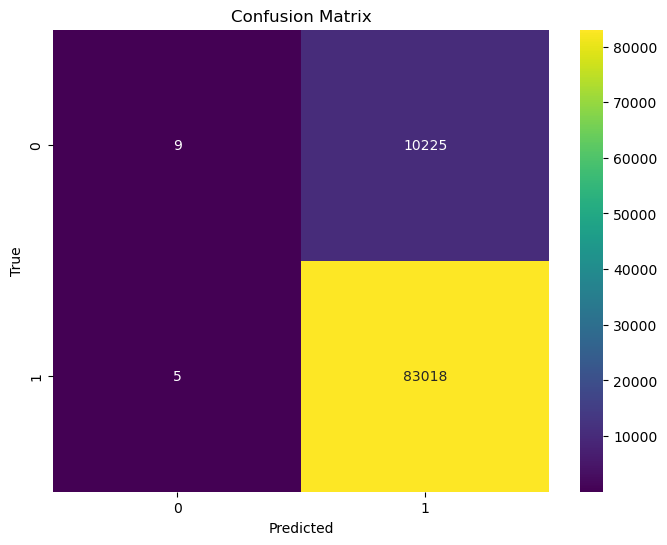

In [29]:
cm = confusion_matrix(y_test, y_test_with_predicted_probs["y_hat_test"])

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Here, we can see the model is baised towards positive class. It is due to the imbalanced data. This is unacceptable, because we do not want bad borrowers to receive the loan. This issue is known as false positive. lets change the threshold to 0.9 and examine the result.

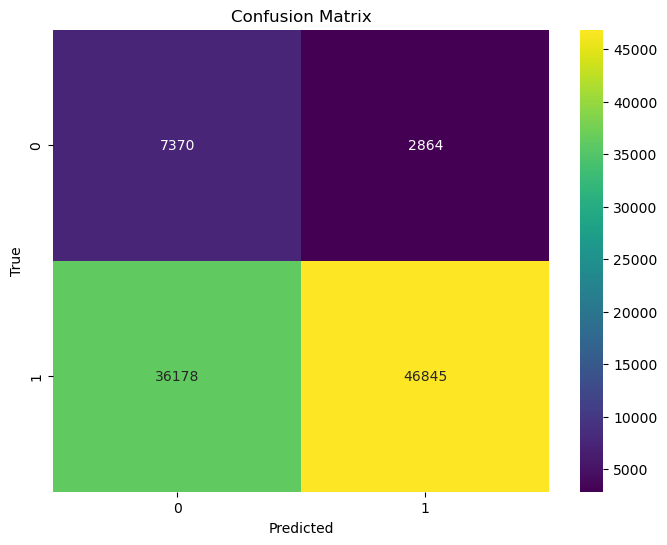

In [30]:
threshold = 0.9
y_test_with_predicted_probs["y_hat_test"] = np.where((y_test_with_predicted_probs["probab_for_positive"] > threshold), 1,0)


cm = confusion_matrix(y_test, y_test_with_predicted_probs["y_hat_test"])

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

We somewhat reconciled the issue with false poitive, but we have more False negative. This model will classify good borrowers as bad borrowers, and this is bad for business.Our goal here is to minimize the risk and maxize the profit.

Lets examine with the AUROC curve 

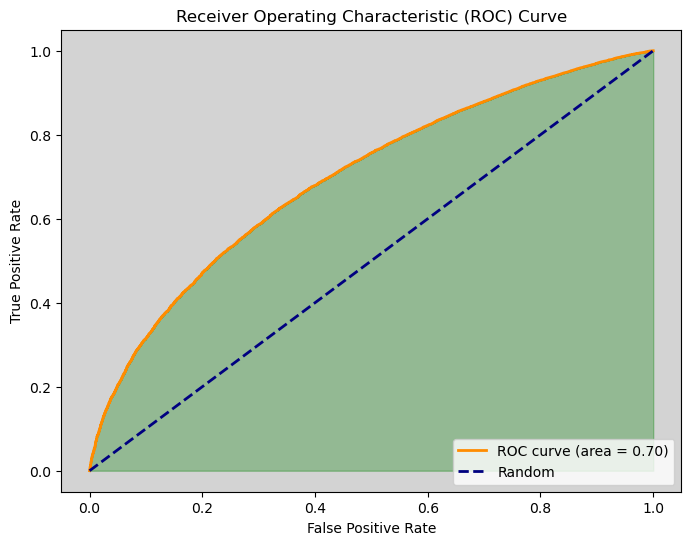

In [31]:

fpr, tpr, thresholds = roc_curve(y_test, y_test_with_predicted_probs["probab_for_positive"])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))

# Set background color and alpha (transparency)
ax.set_facecolor('lightgray')  # You can change 'lightgray' to any color you want
ax.set_alpha(0.3)  # Adjust alpha for transparency


ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
ax.fill_between(fpr, 0, tpr, color='green', alpha=0.3)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')
plt.show()

AUROC Interpretation

| AUROC | Interpretation |
|----------|----------|
| 50% - 60 %  | BAD |
| 60% - 70% | POOR |
| 70% - 80% | FAIR |
| 80% - 90% | GOOD |
| 90% - 100% | EXCELLENT |

##### Gini coefficient and Kolmogorov-Smirnov coefficient Evaluation

The Gini Coefficient measures the inequality between set of itmes (good and bad borrowers) in a population, and it ranges from 0 to 1.  A Gini index of 0 indicates perfect equality, where all elements are the same, while a Gini index of 1 implies maximal inequality.

The Kolmogorov-Smirnov (KS) statistic, often referred to as the Kolmogorov-Smirnov coefficient, is a measure used to quantify the discrepancy between the empirical distribution function (EDF) of observed data and a specified theoretical distribution function. It's commonly used for assessing goodness-of-fit in statistical modeling.


In [32]:
y_test_with_predicted_probs = y_test_with_predicted_probs.sort_values("probab_for_positive")
y_test_with_predicted_probs.tail()

,good_bad,probab_for_positive,y_hat_test
36387,1,0.992044,1
40668,1,0.992573,1
88737,1,0.992615,1
78096,1,0.992659,1
58643,1,0.992812,1


In [33]:
y_test_with_predicted_probs = y_test_with_predicted_probs.reset_index()
y_test_with_predicted_probs.head()

,index,good_bad,probab_for_positive,y_hat_test
0,2503,0,0.380869,0
1,43580,1,0.427291,0
2,68391,0,0.457639,0
3,24804,0,0.465180,0
4,65237,0,0.467715,0


Lets compute, 
- The cumulative % of total population
- the cumulative % of good borrowers 
- the cumulative % of bad borrowers 
  

In [34]:
y_test_with_predicted_probs["cumulative_pop"] = y_test_with_predicted_probs.index + 1
y_test_with_predicted_probs["cumulative_good"] = y_test_with_predicted_probs["good_bad"].cumsum()
y_test_with_predicted_probs["cumulative_bad"] = y_test_with_predicted_probs["cumulative_pop"] -  y_test_with_predicted_probs["good_bad"].cumsum() 

y_test_with_predicted_probs.head()

,index,good_bad,probab_for_positive,y_hat_test,cumulative_pop,cumulative_good,cumulative_bad
0,2503,0,0.380869,0,1,0,1
1,43580,1,0.427291,0,2,1,1
2,68391,0,0.457639,0,3,1,2
3,24804,0,0.465180,0,4,1,3
4,65237,0,0.467715,0,5,1,4


In [35]:
# lets find the respective cumulative proprtion, it is divided by their own total number  
y_test_with_predicted_probs["cumulative_perc_pop"] = y_test_with_predicted_probs['cumulative_pop'] / y_test_with_predicted_probs.shape[0]
y_test_with_predicted_probs["cumulative_perc_good"] = y_test_with_predicted_probs["cumulative_good"] / y_test_with_predicted_probs["good_bad"].sum()
y_test_with_predicted_probs["cumulative_prec_bad"] = y_test_with_predicted_probs["cumulative_bad"] / (y_test_with_predicted_probs.shape[0] - y_test_with_predicted_probs["good_bad"].sum())

In [36]:
y_test_with_predicted_probs.head()

,index,good_bad,probab_for_positive,y_hat_test,cumulative_pop,cumulative_good,cumulative_bad,cumulative_perc_pop,cumulative_perc_good,cumulative_prec_bad
0,2503,0,0.380869,0,1,0,1,0.000011,0.000000,0.000098
1,43580,1,0.427291,0,2,1,1,0.000021,0.000012,0.000098
2,68391,0,0.457639,0,3,1,2,0.000032,0.000012,0.000195
3,24804,0,0.465180,0,4,1,3,0.000043,0.000012,0.000293
4,65237,0,0.467715,0,5,1,4,0.000054,0.000012,0.000391


In [37]:
gini = 2 * roc_auc - 1
gini

0.39146939583701523

Text(0, 0.5, 'Cumulative % Bad')

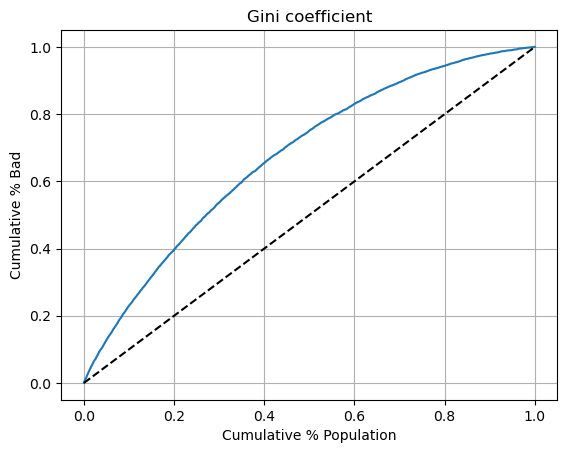

In [38]:
plt.plot(y_test_with_predicted_probs["cumulative_perc_pop"],y_test_with_predicted_probs['cumulative_prec_bad'])
plt.plot(y_test_with_predicted_probs["cumulative_perc_pop"], y_test_with_predicted_probs["cumulative_perc_pop"], linestyle="--", color="k")
plt.grid(True)
plt.title("Gini coefficient")
plt.xlabel("Cumulative % Population")
plt.ylabel("Cumulative % Bad")

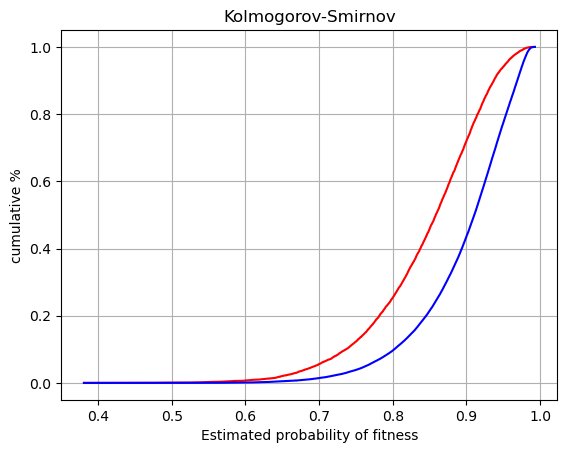

In [39]:
plt.plot(y_test_with_predicted_probs["probab_for_positive"], y_test_with_predicted_probs["cumulative_prec_bad"], color = 'r')
plt.plot(y_test_with_predicted_probs["probab_for_positive"], y_test_with_predicted_probs["cumulative_perc_good"], color = 'b')
plt.grid(True)
plt.xlabel("Estimated probability of fitness")
plt.ylabel("cumulative %")
plt.title("Kolmogorov-Smirnov")
plt.show()

In [40]:
ks = max(y_test_with_predicted_probs["cumulative_prec_bad"] - y_test_with_predicted_probs["cumulative_perc_good"])
ks

0.2879741848697314

The two cumulative distribution functions are far away from each other and the model has satisfactory predictive power.